In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pylab as plt
import numpy as np
import os
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Load dataset

In [2]:
data_dir = Path.cwd().joinpath("dataset")
(ds_train, ds_validation, ds_test), metadata  = tfds.load("tf_flowers", split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], as_supervised=True, with_info=True, data_dir=data_dir)
num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes

## Plot some samples

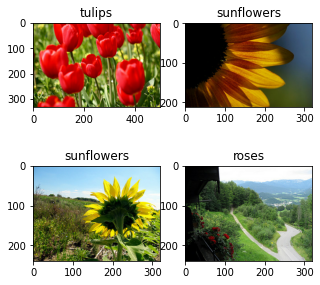

In [3]:
class_names = metadata.features['label'].names
samples = ds_train.take(4)
fig = plt.figure(figsize=(5,5))
for i, ex in enumerate(tfds.as_numpy(samples)):
    np_image , label =ex
    ax = fig.add_subplot(2,2, i + 1)
    ax.set_title(class_names[label])
    ax.imshow(np_image)
plt.show()

## Let's see some Convolutions

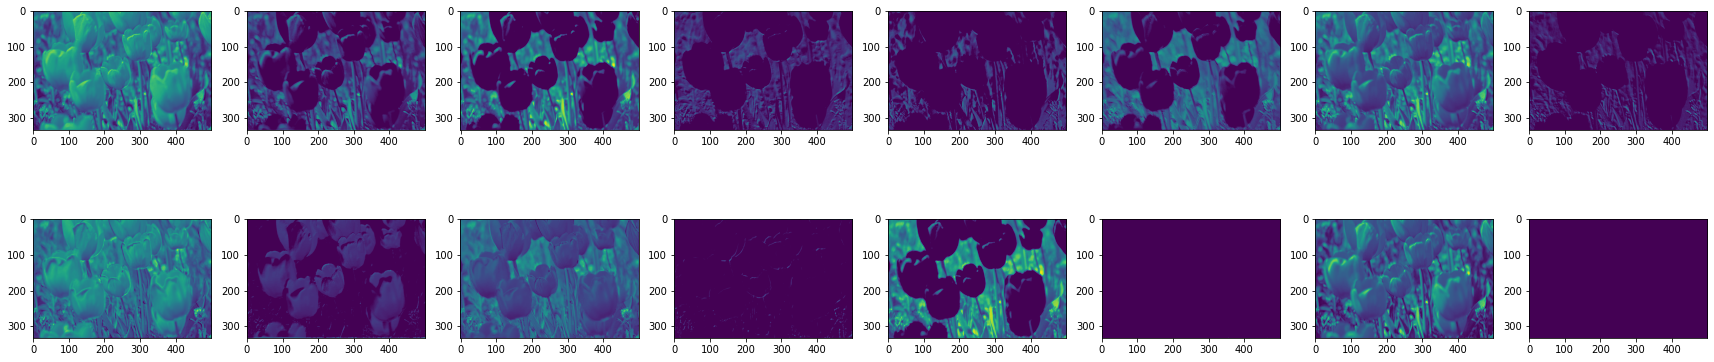

In [4]:
samples = ds_train.take(1)
for i, ex in enumerate(samples):
    image, label = ex
    tf_image = tf.expand_dims(image,0) / 255
    features_maps = layers.Conv2D(16,3, padding="same", activation="relu")(tf_image)
    fig = plt.figure(figsize=(30,30))
    features_maps = features_maps.numpy().squeeze()
    for i, fmap in enumerate(np.rollaxis(features_maps, -1)):
        ax = fig.add_subplot(8,8, i + 1)
        ax.imshow(fmap, vmin=np.min(fmap), vmax=np.max(fmap))
    plt.show()

## Creating our model

In [5]:
IMG_SIZE = 180
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
], name="resize")

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1)
], name="augmentation")

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def prepare(ds,batch_size=32, shuffle=False, augment=False):
  # Resize and rescale the images
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              num_parallel_calls=AUTOTUNE)
  if shuffle:
    ds = ds.shuffle(1000)
  # create batches
  ds = ds.batch(batch_size)
  # apply data augmentation in case that is required
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)
  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

resized_train_ds = prepare(ds_train, shuffle=True, augment=True)
resized_val_ds = prepare(ds_validation)
resized_test_ds = prepare(ds_test, batch_size=1)

In [7]:
model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation="softmax")
])
model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 64)        0

## Train model

In [8]:
epochs=20
history = model.fit(resized_train_ds,validation_data=resized_val_ds, epochs=epochs)

Epoch 1/20
92/92 [==============================] - 39s 412ms/step - loss: 1.5726 - accuracy: 0.3322 - val_loss: 1.2701 - val_accuracy: 0.5232

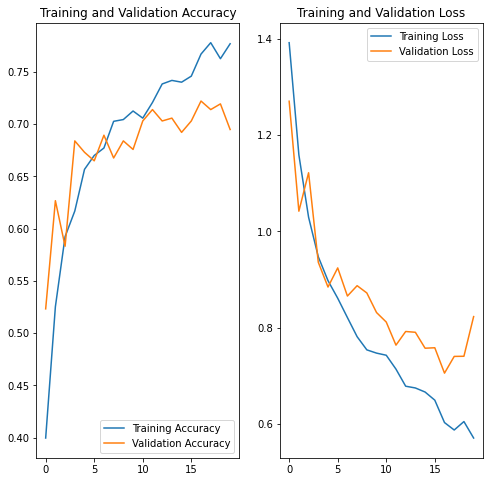

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Export model

In [12]:
tf.saved_model.save(model, "model")

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


This image most likely belongs to sunflowers with a 40.46 percent confidence.


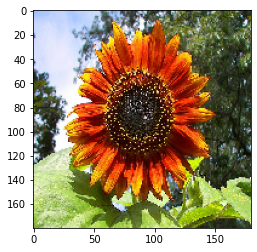

In [13]:
loaded_model = tf.keras.models.load_model('model')
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)
img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(IMG_SIZE, IMG_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_tensor = tf.expand_dims(img_array, 0) # Create a batch
predictions = loaded_model.predict(img_tensor)
score = tf.nn.softmax(predictions[0])
class_names = metadata.features['label'].names
print("This image most likely belongs to {} with a {:.2f} percent confidence." .format(class_names[np.argmax(score)], 100 * np.max(score)))
plt.imshow(img_array.astype(np.uint8))
plt.show()

## Convert to TFLite

In [14]:
# Select mode of optimization
mode = "Speed"
if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT
converter = tf.lite.TFLiteConverter.from_saved_model("model")# YOUR CODE HERE
# Set the optimzations
converter.optimizations = [optimization]# YOUR CODE HERE
# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()# YOUR CODE HERE
# cconvert to tflite
tflite_model_file = Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)


3998544

## For Raspberry PI or test the tflite model

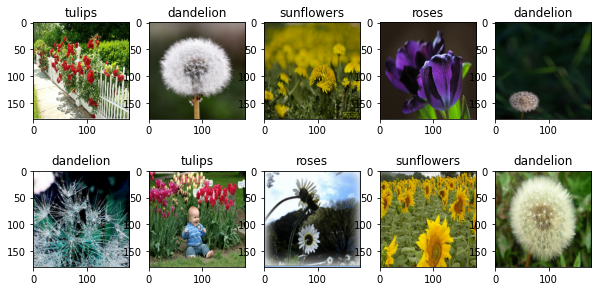

In [30]:
tflite_model_file = Path('model.tflite')
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
# Gather results for the randomly sampled test images
predictions = []
test_labels = []
test_images = []
fig = plt.figure(figsize=(10,5))
for i, (img, label) in enumerate(resized_test_ds.take(10)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions_array = interpreter.get_tensor(output_index)
    predictions_array = np.squeeze(predictions_array)
    predicted_label = np.argmax(predictions_array)
    ax = fig.add_subplot(2,5,i+1)
    img = np.squeeze(img)
    ax.imshow(img)
    ax.set_title(f"{class_names[predicted_label]}")

